# Hyperparameters tuning (MultiOutput estimators for all eigenfrequencies)

The estimators HistGradientBoosting and LightGBM are the most appropriate to predict the frequency of the longitudinal mode. All eigenfrequencies are required as well for a design point and we face to a regression problem with multi targets. That is the reason why the MultiOutputRegressor will be used. Since the best models are determined for a single frequency, we assume that that is the case for the rest of frequencies. The selection of models was skipped, the LGBM Regressor was chosen directly and the hyperparameters will be tuned with a Bayesian method.

In [88]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pickle

In [4]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [5]:
lst_param = df_params.columns.to_list()

# Load variables

The explanatory variables are redefined

In [6]:
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]

X = df_params[lst_expl + lst_slot_class]
X.head()

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,175.06,121.95,240.31,75.993,43.235,78.219,59.508,15.6380,12.0740,1.8138,...,0.88177,25.293,66.060,1.99450,55.3025,57.7760,0,0,0,1
1,173.45,122.77,238.13,81.168,45.859,78.924,57.208,11.7180,9.9347,9.6338,...,4.85900,26.997,56.481,4.80300,50.2765,58.1210,0,0,0,1
2,175.85,116.71,238.10,77.532,45.260,80.099,49.215,2.4722,9.9912,3.8140,...,1.21780,22.264,51.204,0.81847,51.1600,63.3175,0,0,0,1
3,173.51,116.37,238.30,82.428,51.007,74.757,50.840,12.1080,12.8380,1.8759,...,4.16500,37.379,58.304,1.02820,42.6395,61.3350,0,0,0,1
4,175.60,118.72,241.04,76.576,45.981,78.773,64.702,15.8700,11.0240,9.8682,...,0.64304,27.381,51.502,0.74029,51.5485,55.4490,0,0,0,1


# Definition of the target(s)

The goal is to predict a set of eigenfrequencies. Since the target is multidimensional the variables will be stored in the matrix Y. The frequencies around the longitudinal mode are the most interesting in our case. By choosing the frequencies of the modes from 50 to 85, we ensure that the longitudinal mode will always be in the range of selected frequencies.

In [7]:
# Target variables: selection of all frequencies of modes 50 to 85
lst_freq = lst_param[86:122]
#lst_freq = lst_param[86:91] # Frequencies 50 - 54

Y = df_params[lst_freq]
Y.head()

,freq_50,freq_51,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59,...,freq_76,freq_77,freq_78,freq_79,freq_80,freq_81,freq_82,freq_83,freq_84,freq_85
0,15590.889,15672.334,15695.955,15724.891,15744.704,16046.922,16098.367,16103.508,16138.404,16179.628,...,19095.403,19217.965,19279.254,19311.640,20316.043,20572.699,20852.411,21007.577,22042.081,22246.846
1,14858.804,15023.859,15027.617,15125.599,15208.897,15222.020,15239.359,15258.175,15299.975,15351.350,...,18435.617,18516.417,18876.657,19386.656,19896.947,19969.016,20487.623,20537.333,21448.323,21657.039
2,14554.333,15084.777,15112.503,15152.934,15175.380,15181.920,15193.222,15224.571,15283.679,15476.935,...,18788.769,19237.203,19256.489,20087.459,20214.271,20731.439,21076.573,21351.086,21746.397,21981.714
3,14242.832,14790.699,15011.165,15118.437,15162.433,15230.318,15241.376,15272.161,15387.168,15425.608,...,19014.610,19168.498,19288.770,19627.057,20209.177,20551.074,20894.240,21101.402,21288.858,21649.534
4,14922.477,15088.412,15369.606,15384.728,15421.654,15548.109,15735.307,15796.236,15868.130,15894.383,...,19012.524,19354.988,19644.580,19813.899,20459.265,20980.660,21029.941,21649.551,21887.022,22085.694


In [8]:
# New Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=55)

## Multi-Output Regressor

We build a pipeline to include the scaling of the input variables and the Multi-Output wrapping the regressor. The optimization of the hyperparameters will be performed on this pipeline. The start estimator LightGBM is set up with some already customized hyperparameters.
In the case of an multi-output prediction, the coefficient of determination R² calculated by weighting all the targets equally if the parameter multioutput = 'uniform_average' is specified.


In [9]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_lgbm = LGBMRegressor(n_estimators=400,
                      num_leaves=4,
                      min_child_samples=5,
                      learning_rate=0.1,
                      force_col_wise=True)

pipe_start_lgbm = Pipeline([
                        ('scaler', preprocessor),
                        ('multiregressor', MultiOutputRegressor(start_lgbm))
                        ])
    

In [10]:
# Start model
pipe_start_lgbm.fit(X_train, Y_train)
Y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16668.989118
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16847.349643
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17015.896527
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17276.652251
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17539.445753
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the trai

In [11]:
# Check the score of the start model
print ('Score of the test set:', pipe_start_lgbm.score(X_test, Y_test))

Score of the test set: 0.9958759670773522


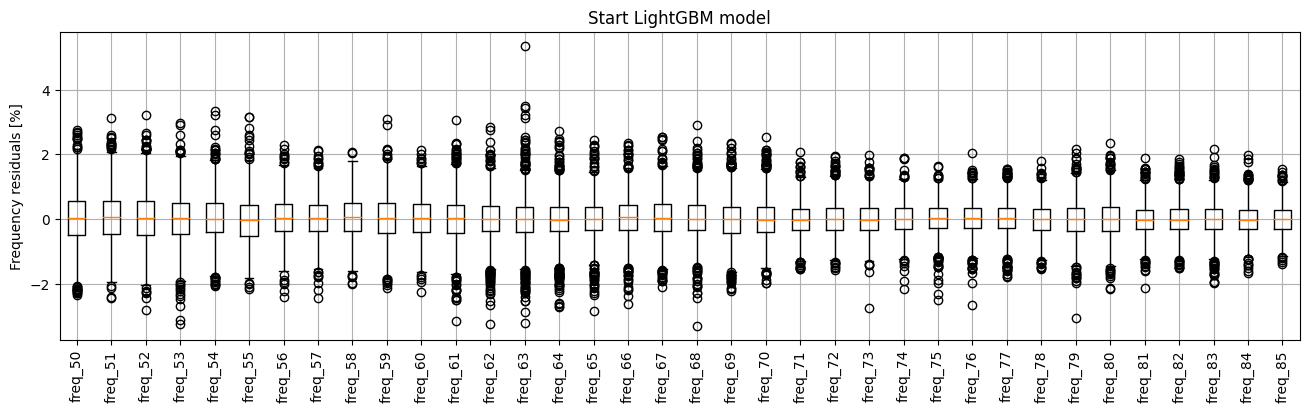

In [12]:
# The residuals are calculated in relation ot the true values
df_freq_residuals = (Y_pred_start_lgbm-Y_test)/Y_test*100

fix, ax = plt.subplots(figsize=(16, 4))
plt.boxplot(df_freq_residuals, labels=lst_freq)
plt.xticks(rotation=90)
plt.grid(True)
plt.title('Start LightGBM model')
plt.ylabel('Frequency residuals [%]')
plt.show()

The relative frequency residual is below 4% (except for only one frequency of one design point)

# Hyperparameters tuning
When the MultiOutputRegressor is wrapping a regressor. the prefix "estimator__" has to be specified to access the underlying LGMB Regressor. BayesSearchCV will apply the same hyperparameters to all regressors in the wrapper.

In [13]:
params_lgbm = {'multiregressor__estimator__n_estimators': Integer(400, 8000),
                'multiregressor__estimator__num_leaves': Integer(4, 12),
                'multiregressor__estimator__min_child_samples': Integer(4, 8),
                'multiregressor__estimator__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'multiregressor__estimator__reg_alpha': Real(1e-5, 1e-2, prior='log-uniform'),
                'multiregressor__estimator__reg_lambda': Real(1e-5, 1e-2, prior='log-uniform')}

bayes_search_lgbm = BayesSearchCV(estimator=pipe_start_lgbm,
                                search_spaces=params_lgbm,
                                n_iter=32,
                                scoring='r2',
                                random_state=55,
                                cv=KFold(n_splits=5, shuffle=True, random_state=55),
                                verbose=True,
                                n_jobs=-1)

In [14]:
# Perform the Bayesian search
bayes_search_lgbm.fit(X_train, Y_train)
print ('Best score:', bayes_search_lgbm.best_score_)
print ('Best parameters:', bayes_search_lgbm.best_params_)
print ('Score of the test set:', bayes_search_lgbm.score(X_test, Y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

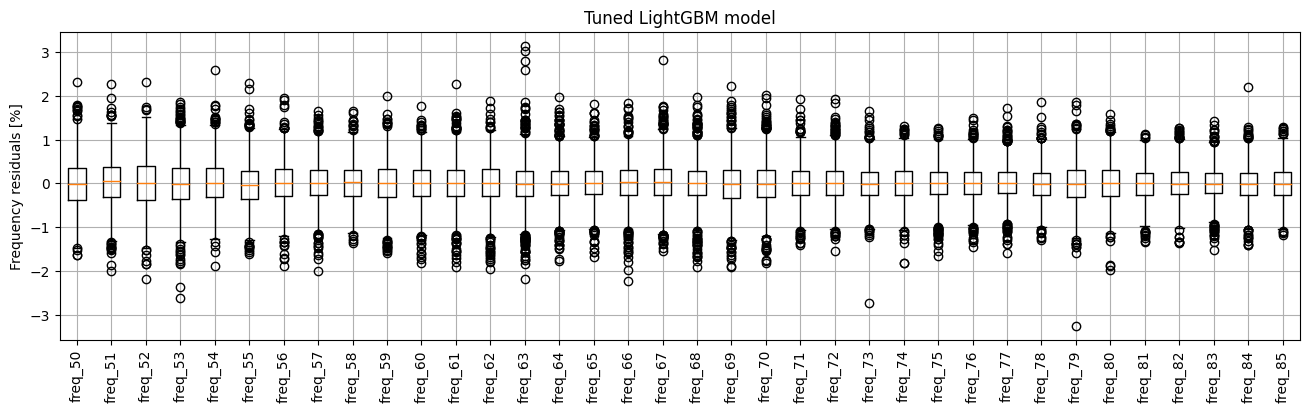

In [118]:
# Prediction
Y_pred_tuned_lgbm = bayes_search_lgbm.predict(X_test)
Y_pred_tuned_lgbm = pd.DataFrame(Y_pred_tuned_lgbm, index=X_test.index, columns=lst_freq)

# Calculation of the residuals
df_freq_residuals_tuned = (Y_pred_tuned_lgbm-Y_test)/Y_test*100

fix, ax = plt.subplots(figsize=(16, 4))
plt.boxplot(df_freq_residuals_tuned, labels=lst_freq)
plt.xticks(rotation=90)
plt.grid(True)
plt.title('Tuned LightGBM model')
plt.ylabel('Frequency residuals [%]')
plt.show()

The relative frequency residuals are below 1.5% (outliers excluded) and the score on the test is improved from 0.9959 to 0.9976.

The mean absolute percentage error (MAPE) quantifies the average absolute difference between predicted and observed values as percentage of the observed (true) values. This metric can be appropriate in our specific case, where the target variables span a broad range of frequencies (between 13 and 27 kHz). The argument "raw_values" allows to determine the error for each frequency.

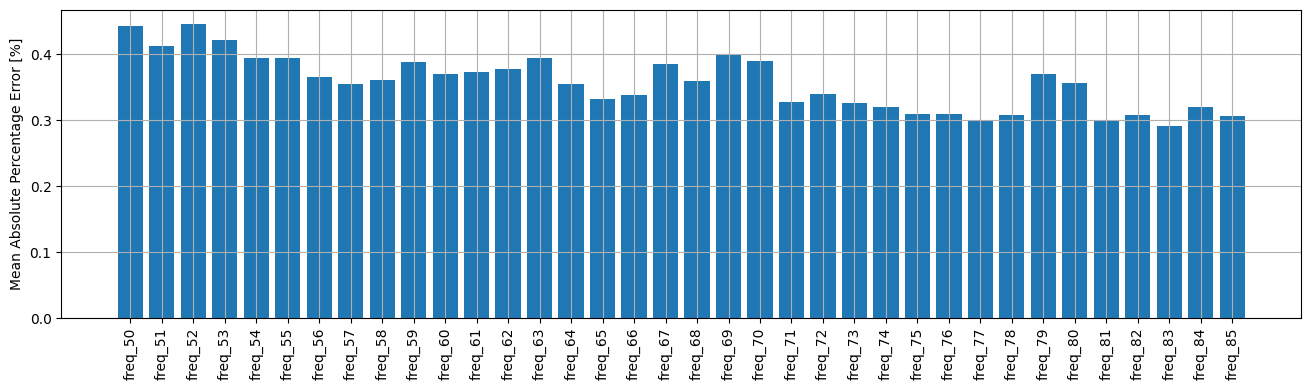

In [119]:
# Calculation of the Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(Y_test, Y_pred_tuned_lgbm, multioutput='raw_values')

n_freq = len(lst_freq)
fig = plt.figure(figsize=(16, 4))
plt.bar(x=range(n_freq), height=mape*100)
plt.ylabel('Mean Absolute Percentage Error [%]')
plt.xticks(range(n_freq), lst_freq, rotation=90)
plt.grid()
plt.show()

The frequencies of the modes located near the longitudinal mode matter, but the position of the longitudinal mode depends mostly on the slot class. For this reason we should calculate the mean absolute error of frequency separately

In [134]:
# Visualization of the mean absolute errors according to the slot class

# Defines ranges of positions where the longitudinal mode is located
lst_freq_slot22 = lst_param[86:97]      # Frequencies 50 - 60
lst_freq_slot41 = lst_param[91:102]      # Frequencies 55 - 65
lst_freq_slot32 = lst_param[98:109]      # Frequencies 62 - 72
lst_freq_slot42 = lst_param[111:122]      # Frequencies 75 - 85

idx_slot22 = X_test[X_test['slot_2-2'] == 1].index
idx_slot41 = X_test[X_test['slot_4-1'] == 1].index
idx_slot32 = X_test[X_test['slot_3-2'] == 1].index
idx_slot42 = X_test[X_test['slot_4-2'] == 1].index

Y_test_slot22 = Y_test.loc[idx_slot22, lst_freq_slot22]
Y_test_slot41 = Y_test.loc[idx_slot41, lst_freq_slot41]
Y_test_slot32 = Y_test.loc[idx_slot32, lst_freq_slot32]
Y_test_slot42 = Y_test.loc[idx_slot42, lst_freq_slot42]

Y_pred_slot22 = Y_pred_tuned_lgbm.loc[idx_slot22, lst_freq_slot22]
Y_pred_slot41 = Y_pred_tuned_lgbm.loc[idx_slot41, lst_freq_slot41]
Y_pred_slot32 = Y_pred_tuned_lgbm.loc[idx_slot32, lst_freq_slot32]
Y_pred_slot42 = Y_pred_tuned_lgbm.loc[idx_slot42, lst_freq_slot42]

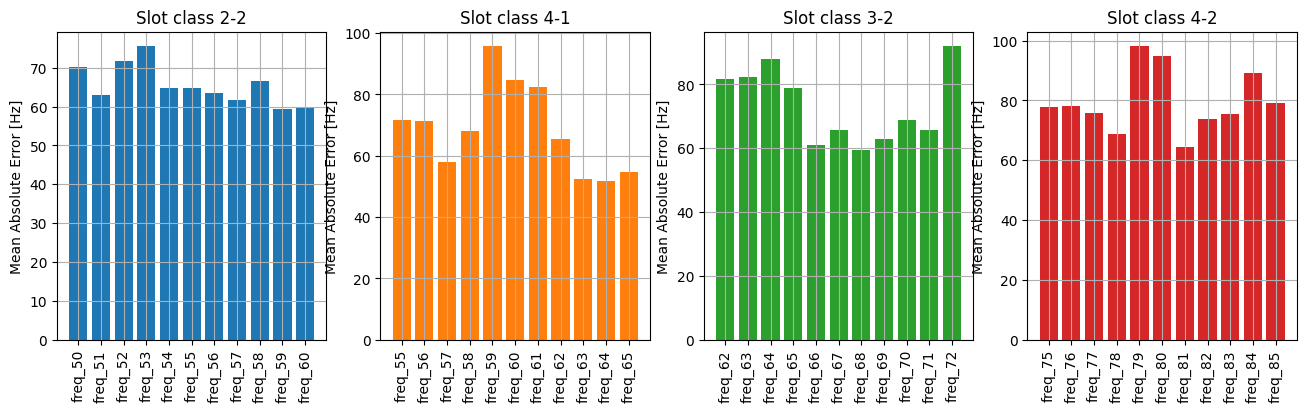

In [133]:
mae_slot22 = mean_absolute_error(Y_test_slot22[lst_freq_slot22], Y_pred_slot22[lst_freq_slot22], multioutput='raw_values')
mae_slot41 = mean_absolute_error(Y_test_slot41[lst_freq_slot41], Y_pred_slot41[lst_freq_slot41], multioutput='raw_values')
mae_slot32 = mean_absolute_error(Y_test_slot32[lst_freq_slot32], Y_pred_slot32[lst_freq_slot32], multioutput='raw_values')
mae_slot42 = mean_absolute_error(Y_test_slot42[lst_freq_slot42], Y_pred_slot42[lst_freq_slot42], multioutput='raw_values')

fig = plt.figure(figsize=(16, 4))

ax0 = fig.add_subplot(141)
plt.bar(x=range(len(lst_freq_slot22)), height=mae_slot22, color='tab:blue')
plt.ylabel('Mean Absolute Error [Hz]')
plt.xticks(range(len(lst_freq_slot22)), lst_freq_slot22, rotation=90)
plt.title('Slot class 2-2')
plt.grid()

ax1 = fig.add_subplot(142)
plt.bar(x=range(len(lst_freq_slot41)), height=mae_slot41, color='tab:orange')
plt.ylabel('Mean Absolute Error [Hz]')
plt.xticks(range(len(lst_freq_slot41)), lst_freq_slot41, rotation=90)
plt.title('Slot class 4-1')
plt.grid()

ax2 = fig.add_subplot(143)
plt.bar(x=range(len(lst_freq_slot32)), height=mae_slot32, color='tab:green')
plt.ylabel('Mean Absolute Error [Hz]')
plt.xticks(range(len(lst_freq_slot32)), lst_freq_slot32, rotation=90)
plt.title('Slot class 3-2')
plt.grid()

ax3 = fig.add_subplot(144)
plt.bar(x=range(len(lst_freq_slot42)), height=mae_slot42, color='tab:red')
plt.ylabel('Mean Absolute Error [Hz]')
plt.xticks(range(len(lst_freq_slot42)), lst_freq_slot42, rotation=90)
plt.title('Slot class 4-2')
plt.grid()


# Conclusion

 The mean absolute error is increasing with the slot class and therefore with the complexity of the geometry. A mean error of 100 Hz could be at the limit of a good prediction in case of a very close neighbor mode.

Dump fitted models as pickle files

In [50]:
dump_dir = os.path.join(base_dir, 'Scripts', 'model_dumps')

pickle.dump(bayes_search_lgbm.best_estimator_, open(os.path.join(dump_dir, '4_model_lgbm_tuned_all_frequencies.pkl'), 'wb'))